# AID 1706

This notebook looks at a drug screen against SARS-CoV1 Papain-like protease (PL-pro). PL-pro is essential for virus assembly. The screen was carried out at * by \* in \*. The assay is a QFRET-based measure of protease activity inhibition in response to the test compounds.  The test compounds are from the * screening library. In \*.ipynb we used http requests to download this data from the pubchem database and saved the 29 MB output into ```AID_1706.csv```.

This notebook explores the dataset by calculating some physical-chemistry properties of the screening set, and looks at parralelizing   the calucualtions. After that, we'll look at sub-structure searching and fingerprints. The functions should be reusable in future machine learning tasks.

#### Breakdown of dataset

The dataset contains 290893 compound entries. Each entry has the following columns:

```PUBCHEM_RESULT_TAG```: 

```PUBCHEM_SID```: Substance ID - useful for mixtures

```PUBCHEM_CID```: Compound ID - applies if a single compound was tested

```PUBCHEM_ACTIVITY_OUTCOME```: Pubchem assigned labels: ```Inactive``` or ```Active```

```PUBCHEM_ACTIVITY_SCORE```: Pubchem normalized assay result

```Inhibition```: % inhibition of PL-Pro @ 6µM test compound (range: -500:100)

```smiles```: Compound structure description

In [3]:
import pandas as pd

df = pd.read_csv('AID_1706.csv', index_col=0)

print(f'Number of datapoints:\t{len(df)}')
df.head()

Number of datapoints:	290893


,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Inhibition,smiles
0,445,842574,644842,Inactive,6.0,4.94,COC(=O)C1=CC=CC=C1NC(=O)C2CC(=O)N(C2)C3=CC=C(C...
1,660,842798,645071,Inactive,0.0,0.13,CCOC(=O)CNC(=O)CSC1=NN=NN1C2=C(C=CC(=C2)C)C
2,821,842962,645240,Inactive,0.0,-7.40,C1CN(CCC1(C2=CN=CC=C2)O)C(=O)C3=CC=CC=C3F
3,1611,843768,646070,Inactive,0.0,-0.40,CC12CC3(CN(C1)C(N(C2)C3)C4=CC(=C(C=C4)O)OC)C
4,1773,843933,646239,Inactive,3.0,2.74,C1CC(OC1)CN(CC2=CC3=CC4=C(C=C3NC2=O)OCCO4)S(=O...


# The metric
To try to understand the difference between ```PUBCHEM_ACTIVITY_SCORE``` and ```Inhibition``` and their relationship with the ```PUBCHEM_ACTIVITY_OUTCOME``` , I plotted ```PUBCHEM_ACTIVITY_SCORE``` against ```PUBCHEM_ACTIVITY_OUTCOME``` and colored the points by ```Inhibition```. The PubChem Activity Score is zero for all compounds with negative ```Inhibition``` and linearly maps to ```Inhibition``` $>$. The lowest PubChem Activity Score in the hits ```df.loc[df['PUBCHEM_ACTIVITY_OUTCOME']=='Active']``` is ```15.0```, so that's the activity cutoff.

# PubChem Activiy Score

I can fit this 'curve' to the data:
$$Pubchem Activity Score = max(0,m \times Inhibition)$$
where $m$ is the gradient of the line where $x >0$. I'll fit the curve with [```scipy.optimize.curve_fit```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which uses [nonlinear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares) to optimise the function parameters. 

```python
?curve_fit
curve_fit
Signature:curve_fit(f,xdata,ydata)
Parameters
----------
f : callable
    The model function, f(x, ...).  It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : array_like or object
    The independent variable where the data is measured.
    Should usually be an M-length sequence or an (k,M)-shaped array for
    functions with k predictors, but can actually be any object.
ydata : array_like
    The dependent data, a length M array - nominally ``f(xdata, ...)``.
p0 : array_like, optional
    
Returns
-------
popt : array
    Optimal values for the parameters so that the sum of the squared
    residuals of ``f(xdata, *popt) - ydata`` is minimized
pcov : 2d array
    The estimated covariance of popt. The diagonals provide the variance
    of the parameter estimate. To compute one standard deviation errors
    on the parameters use ``perr = np.sqrt(np.diag(pcov))``.
```

PUBCHEM_ACTIVITY_SCORE = max(0, 1.143 * Inhibition)
error??
Coumpounds considered active if  PUBCHEM_ACTIVITY_SCORE > 15.0


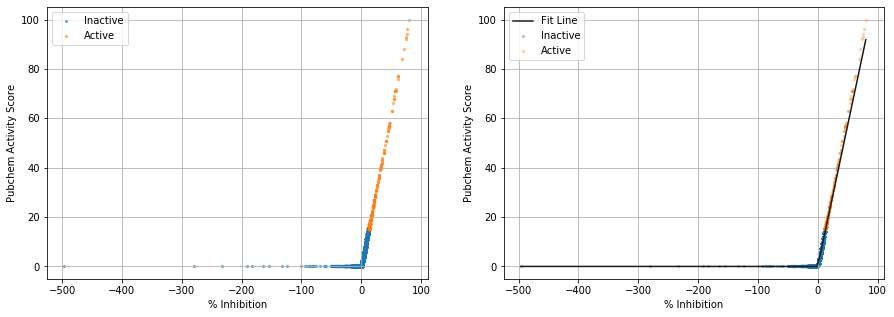

In [4]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

####### curve fitting ########

def curve(x,m):
    return np.maximum(m*x, 0)

param, covariance = curve_fit(curve, df['Inhibition'], df['PUBCHEM_ACTIVITY_SCORE'])

print(f'PUBCHEM_ACTIVITY_SCORE = max(0, {round(param.item(), 3)} * Inhibition)')
print(f'error??')

inactive = df.loc[df['PUBCHEM_ACTIVITY_OUTCOME']=='Inactive']
active = df.loc[df['PUBCHEM_ACTIVITY_OUTCOME']=='Active']

print(f"Coumpounds considered active if  PUBCHEM_ACTIVITY_SCORE > {active['PUBCHEM_ACTIVITY_SCORE'].min()}")

###### plotting #########


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (15,5))


ax1.scatter(inactive['Inhibition'], inactive['PUBCHEM_ACTIVITY_SCORE'], s=5, alpha = 0.5)
ax1.scatter(active['Inhibition'], active['PUBCHEM_ACTIVITY_SCORE'],s=5,alpha = 0.5)
ax1.legend(['Inactive','Active'])
ax1.set_xlabel('% Inhibition')
ax1.set_ylabel('Pubchem Activity Score')
ax1.grid()


x = np.linspace(df['Inhibition'].min(), df['Inhibition'].max(), 100)

ax2.scatter(inactive['Inhibition'], inactive['PUBCHEM_ACTIVITY_SCORE'], s=5, alpha = 0.3)
ax2.scatter(active['Inhibition'], active['PUBCHEM_ACTIVITY_SCORE'],s=5,alpha = 0.3)
ax2.plot(x, curve(x, param), color = '0.1')

ax2.legend(['Fit Line','Inactive','Active'])
ax2.set_xlabel('% Inhibition')
ax2.set_ylabel('Pubchem Activity Score')
ax2.grid()

plt.show()

## Negative inhibition
In the QFRET assay, induced fluoresence decreases with distance $r$ between the two flurophores at $1/r^6$ (?) so  active PL-Pro will cleave the two fluorophores and induced fluoresence decreases. Fluoresence is high when PL-Pro is inhibited. Artifacts in the assay include dust ......... according to the authors, which may be sources of fluoresence and measure at a negative inhibition.

The curve $Pubchem Activity Score = max(0,1.143 \times Inhibition)$ transforms inhibition measures to PubChem Activity Scores.]

# Screening compounds
In the next section, I'll use ```rdkit``` to visualise some of the screening compounds, and build some functions to calculate molecular properties, search for substructures and generate chemical fingerprints, which can be used in model building. I'll also speed up the calculations by taking advantage of ```multiprocessing``` and ```multithreading```.

,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Inhibition,Structure
847,Inactive,9.0,7.59,
91,Inactive,0.0,0.01,
140,Inactive,3.0,2.92,
24,Inactive,3.0,2.72,
857,Inactive,0.0,-6.09,

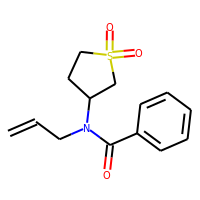
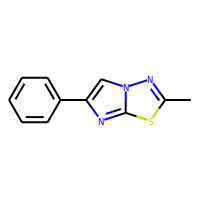
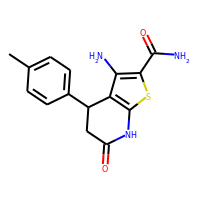
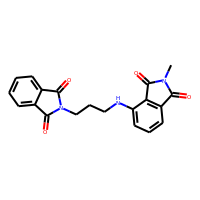
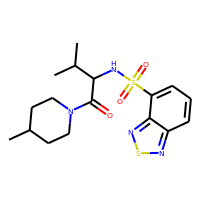

In [11]:
from rdkit import Chem
from rdkit.Chem import PandasTools

df_sample = df.sample(1000)

# render the compounds in the DataFrame
PandasTools.AddMoleculeColumnToFrame(df_sample, 
                                     smilesCol = 'smiles',
                                     molCol='Structure')

df_sample[['PUBCHEM_ACTIVITY_OUTCOME',
           'PUBCHEM_ACTIVITY_SCORE',
           'Inhibition',
          'Structure']][0:5]

# Chemical and Physical Properties - Lipinski's Role of 5

[**Lipinski's rule of 5**](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five) are (4) well established, but loose rules used to guide drug design that aim to predict the oral bioavailability of a compound. They are:
* **Mass < 500 Da**
* **[LogP](https://en.wikipedia.org/wiki/Octanol-water_partition_coefficient) < 5**
* **# H-bond donors < 5**
* **# H-bond acceptors < 10**
These rules help guide chemists towards structures that have both affinity for the target, and oral bioavailability, and therefore a higher chance of passing clinical trials.```#ref```

#### In this Section
We'll calculate the Lipinski descriptors for all compounds (290,893). Scaling this calculation to a large dataset can be slow, so we'll compare some tricks to speed up large calculations.

In the cell below, we define a function that calculates Lipinski's physical and chemical features for a single molecule, given as a SMILES code. Note that after the ```rdkit mol``` is generated, implicit hydrogens are added prior to our calculations. Many useful descriptor functions are in ```rdkit.Chem.AllChem```, which contains [all rdkit chemistry modules](https://www.rdkit.org/docs/source/rdkit.Chem.AllChem.html).

In [12]:
from rdkit.Chem import Crippen, AllChem

def PhysChemFeatures(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    dictionary = {'MolWT':AllChem.CalcExactMolWt(mol),
                  'LogP':Chem.Crippen.MolLogP(mol),
                  'HBondDonors': AllChem.CalcNumLipinskiHBD(mol),
                  'HBondAcceptors': AllChem.CalcNumLipinskiHBA(mol)}
    
    return pd.Series(dictionary) # easy to pack into a dataframe

df.sample(1000)['smiles'].apply(PhysChemFeatures).head()

,MolWT,LogP,HBondDonors,HBondAcceptors
787,313.113650,4.01010,0.0,3.0
336,226.121846,2.37584,0.0,4.0
597,379.192963,3.25420,2.0,6.0
526,314.126657,2.32070,0.0,6.0
300,369.094726,3.63378,0.0,5.0


## Parralelism
Functions can be run in parralel if the calculations are independent of each other, therefore we can calculate physical chemistry descriptors for each molecule in parralel. In this sectin we'll compare a few methods of parralelism with non-parralel counterparts. 

A useful command for timing a function is the ```%%timeit``` magic command. When executed in a cell, it runs the cell seven times and prints the mean time of completion and the standard deviation. 


In [13]:
%%timeit
df.sample(1000)['smiles'].apply(PhysChemFeatures)

1.07 s ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Applying a functions to a pandas series is an example of serial execution - one operation after another. It essentially wraps a loop that performs the function on each value one at a time. ```#check boradcasting```

Our two options for speeding up our physical chemistry calculations  are **multi-threading** and **multi-processing**. 

#### Multithreading
Multithreading is efficient task scheduling. It's efficient for I/O (input/output) bound programs, which have to wait for responses from external resources (e.g. sending http requests). In this case, once the first request is sent and waiting for a response, the second request can be sent. 

As far is I know, our ```PhysChemFeatures``` function is not I/O bound, but CPU-bound - limited by the speed of the processor. I've written a function below that uses multithreading for comparison. It uses the ```concrrent``` module from the standard python library. It uses the context manager to start a 'thread pool executor', automatically closing it down after.  The thread pool executor has jobs submitted to it using the ```map``` function, and then manages their execution. The ```results``` object is a generator, which is unpacked using ```list``` before being packaged into a ```DataFrame```. 

#### Multiprocessing
Multiprocessing is parralelism. CPUs are allocated to a resource Pool, which can be used to allocate CPU time. At runtime, the job is divided between the CPUs and excuted in parralel. Multiprocessing is suitable for CPU-bound processes, like our ```PhysChemFeatures``` function presumably is. The disadvantage of multiprocessing is the overhead in distrubuting jobs between CPUs, may not pay off with a small number of jobs.

The ```multiprocess```  function I've written below is syntacticly similar to the ```multithread``` function, except it maps jobs to  ```multiprocessing.Pool``` rather than ```concurrent.futures.ThreadPoolExecutor```. It also takes the argmuent ```processes``` which I've set to my CPU count - 1, leaving me with one whilst it works.

#### Testing
I've compared these two functions agaist eachother below to see how well they scale to large datasets.

100%|██████████| 5/5 [01:32<00:00, 18.49s/it]


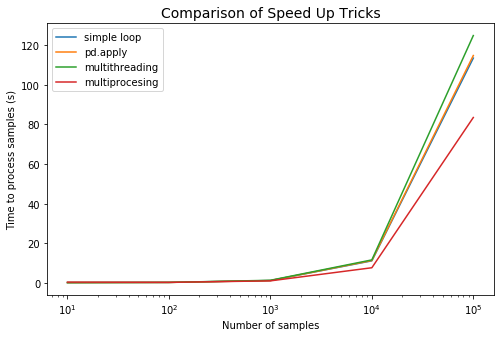

In [14]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
import time
from tqdm import tqdm

def simple_loop(smiles, fn):
    return pd.DataFrame([fn(i) for i in smiles])

def pandas_apply(smiles, fn):
    return smiles.apply(fn)

def multithread(smiles, fn):
    with ThreadPoolExecutor(max_workers=3) as executor:
        results = executor.map(fn, smiles)
    return pd.DataFrame(list(results))

def multiprocess(smiles, fn):
    with Pool(processes = (cpu_count() - 1)) as pool:
        results = pool.map(fn, smiles)
    pool.join()
    return pd.DataFrame(results)

def test_speed(fn, ns):
    # fn: function
    # ns: list of sample sizes
    # returns: function exectution time for each sample size in ns
    time_elapsed = []
    for i in tqdm(ns):
        start = time.time()
        _ = fn(df['smiles'].sample(i), PhysChemFeatures)
        finish = time.time()
        elapsed = finish-start
        time_elapsed.append(elapsed)
    return time_elapsed

sample_sizes = [1*(10**i) for i in range(1, 6)]

simple_loop_times = test_speed(simple_loop, sample_sizes)
applied_times = test_speed(pandas_apply, sample_sizes)
multithread_times = test_speed(multithread, sample_sizes)
multiprocess_times = test_speed(multiprocess, sample_sizes)

plt.figure(figsize = (8,5))
plt.plot(sample_sizes, simple_loop_times)
plt.plot(sample_sizes, applied_times)
plt.plot(sample_sizes, multithread_times)
plt.plot(sample_sizes,multiprocess_times)
plt.title('Comparison of Speed Up Tricks', fontsize=14)
plt.legend(['simple loop','pd.apply','multithreading','multiprocesing'])
plt.xlabel('Number of samples')
plt.xticks(sample_sizes)
plt.ylabel('Time to process samples (s)')
plt.xscale('log')

plt.show()

### Results
Multi-threading appears much faster for large samples. I'll use the ```multithread(data, fn)``` function to map ```PhysChemFeatures``` to the whole dataset.

In [15]:
start_timer = time.time()

physchem_features = multithread(df['smiles'], PhysChemFeatures)

stop_timer = time.time()

print(f'{round(stop_timer - start_timer)} s to apply function to {len(df)} cells')

physchem_features.head()

367 s to apply function to 290893 cells


,MolWT,LogP,HBondDonors,HBondAcceptors
0,356.117235,2.60390,1.0,6.0
1,349.120860,1.05054,1.0,8.0
2,300.127406,2.34450,1.0,4.0
3,288.183778,2.44690,1.0,4.0
4,456.135507,2.66920,1.0,8.0


In [16]:
#sequential filter for compounds that conform to all 4 of Lipnski's rules
lipinski_friendly = physchem_features.loc[physchem_features['MolWT']<500]\
.loc[physchem_features['LogP']<5]\
.loc[physchem_features['HBondDonors']<5]\
.loc[physchem_features['HBondAcceptors'] <10]

not_lipinski = physchem_features.drop(lipinski_friendly.index)

print(f"Percentage of compounds that conform to all four of Lipinski's rules: \
{100* round(len(lipinski_friendly)/len(physchem_features), 3)} %")

Percentage of compounds that conform to all four of Lipinski's rules: 91.9 %


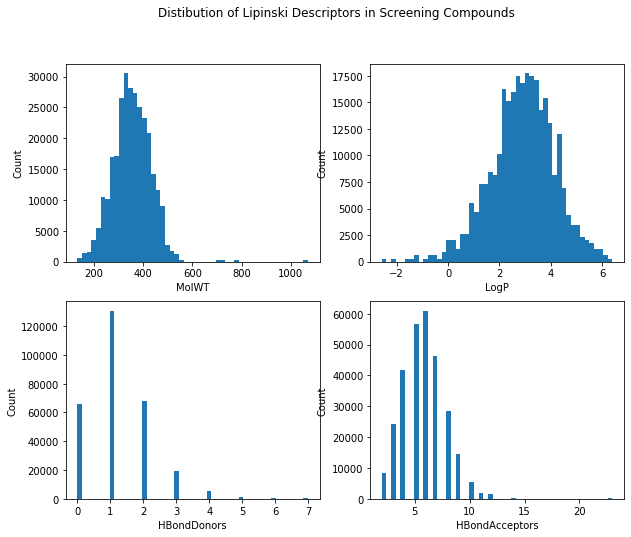

In [17]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10,8))
fig.suptitle('Distibution of Lipinski Descriptors in Screening Compounds')

for i,j in zip([ax1, ax2, ax3, ax4], physchem_features.columns):
    i.hist(physchem_features[j], bins = 50)
    i.set_xlabel(j)
    i.set_ylabel('Count')
    
#plt.tight_layout()
# need to sort out the y label
plt.show()

## Scaffolds

Scaffolds of compounds are underlying structural elements of a compound that can be used to identify similarities between compounds based on shape alone. Detecting scaffolds was introduced by [**Murcko and Bemis (1996)**](https://pubs.acs.org/doi/10.1021/jm9602928) to find similarities between approved drugs. Often, compounds with the same scaffold have similar bioactivity ```#ref```

[**Murcko and Bemis (1996)**](https://pubs.acs.org/doi/10.1021/jm9602928) categorize structural features of molecules into four categories:
* **Ring Systems:** cycles and fused cycles
* **Linker Atoms:** atoms in the direct path between rings
* **Side Chain Atoms:** any non-ring and non-linker atoms
* **FrameWork =** **Ring systems** + **Linker atoms**

The scaffold is the framework - just rings and linkers. 

In this section, we'll look at the most popular scaffolds in our dataset. ```rdkit.Chem.PandasTools``` has a function that will generate the smiles of a scaffold

,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Structure,Scaffold
847,Inactive,9.0,,
91,Inactive,0.0,,
140,Inactive,3.0,,

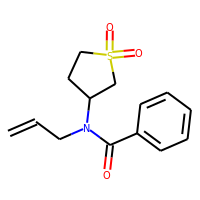
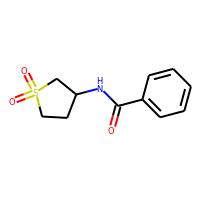
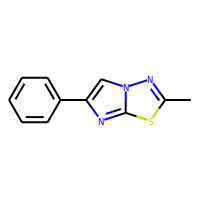
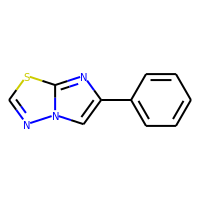
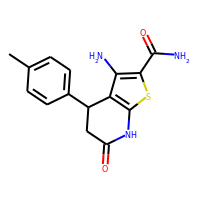
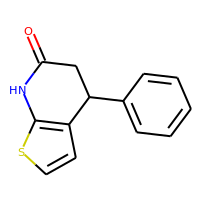

In [18]:
PandasTools.AddMurckoToFrame(df_sample, molCol = 'Structure', MurckoCol='Scaffold smiles')
PandasTools.AddMoleculeColumnToFrame(df_sample, smilesCol='Scaffold smiles',molCol='Scaffold')
df_sample[['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE','Structure','Scaffold']][0:3]

In [19]:
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles


start_timer = time.time()

scaffolds = multiprocess(df['smiles'], MurckoScaffoldSmilesFromSmiles)

stop_timer = time.time()

print(f'{round(stop_timer - start_timer)} s to apply function to {len(df)} cells')

61 s to apply function to 290893 cells


## Most popular scaffolds

The dataset is bias to some scaffolds, e.g. benzene. Unbiased sampling will be essential to models. 

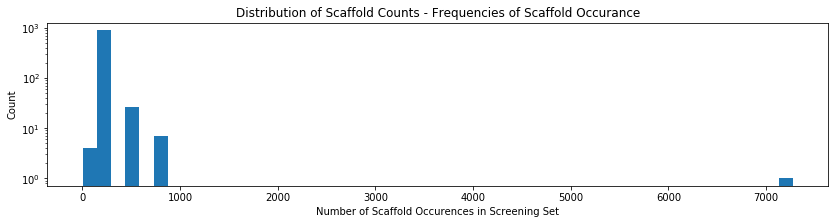

In [38]:
import seaborn as sns
scaffold_counts = scaffolds[0].value_counts().reset_index()

plt.figure(figsize = (14,3))
plt.title('Distribution of Scaffold Counts - Frequencies of Scaffold Occurance')
plt.hist(scaffold_counts[0], bins=50)
plt.ylabel('Count')
plt.xlabel('Number of Scaffold Occurences in Screening Set')
plt.yscale('log')
plt.show()

Benzene is the most popular scaffold. 

,smiles,count,ROMol
0,c1ccccc1,7273,
1,C1C2CC3CC1CC(C2)C3,873,
2,O=C(Nc1ccccc1)c1ccccc1,873,
3,O=S(=O)(NCc1ccccc1)c1ccccc1,873,
4,O=C(COc1ccccc1)Nc1ccccc1,872,

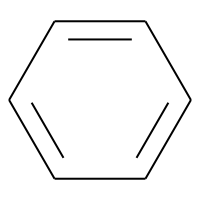
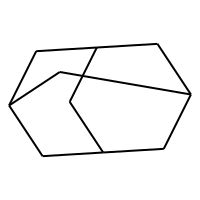
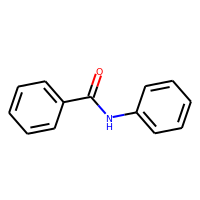
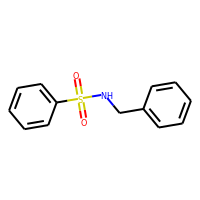
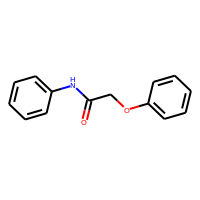

In [13]:
scaffold_counts.columns = ['smiles','count']
PandasTools.AddMoleculeColumnToFrame(scaffold_counts, smilesCol = 'smiles')
scaffold_counts.nlargest(5, 'count')

If I need to sample a particular scaffold I could use:

In [45]:
# join scaffolds to df
df['scaffolds'] = scaffolds
benzenes = df.loc[df['scaffolds'] == 'c1ccccc1',:]
benzenes.head()

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Inhibition,smiles,scaffolds
55,15489,859874,661178,Inactive,4.0,3.44,CCCOC1=CC=C(C=C1)CSC(CC(=O)O)C(=O)O,c1ccccc1
62,18051,862629,663863,Inactive,0.0,-3.25,CC(C(=O)OC)NC(=O)NC1=CC=C(C=C1)S(=O)(=O)N,c1ccccc1
81,23765,3713564,2554278,Inactive,0.0,0.24,CCCS(=O)(=O)NC1=C(C=CC(=C1)C(F)(F)F)OCCOC,c1ccccc1
167,50623,4265322,2211253,Inactive,5.0,4.56,COCCCNC(=O)NC1=C(C=C(C=C1)Br)Cl,c1ccccc1
211,63137,7978072,5324273,Inactive,3.0,3.20,CC(=NO)C=CC1=CC=CC=C1,c1ccccc1


## Fragments and Fingerprints 

As well as calculating physical properties of our molecules, we can also search for the presence of any given sub-strucuture. Sub-structure searching (SSS) can be used to interrogate a dataset,  generate molecular features for a model and indentify similar compounds. Given it's usefulness, SSS is a core concept of cheminformatics.

SSS is a [**graph isomorphism**](https://en.wikipedia.org/wiki/Graph_isomorphism) problem, where here *graph* refers to a network of **nodes** (atoms) and **edges** (bonds). In [**graph theory**](https://en.wikipedia.org/wiki/Graph_theory), a [**graph**](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) is a data structure that contains objects (nodes) and relationships between them (edges). Nodes and edges contain information about items and the relationship between them. *Graphs* are a data structure that used to describe:

|**Graph**|**Nodes**|**Edges**|
|----|-----|----|
|Molecules|Atoms|Bonds|
|Protein Structures|Amino acids|Contacts|
|Metabolic networks|Compounds|Enzyme transformations|
|Social networks|People|Friendship|
|Street maps|Intersections|Roads|

Graphs are as a common data structure in the biosciences as other fields, and to navigate and extract information from them, there are plenty of useful [**algorithms**](https://en.wikipedia.org/wiki/Graph_theory#Algorithms). SSS, however is an [**NP-complete problem**](https://en.wikipedia.org/wiki/NP-completeness), a term which in [**computational complexity theory**](https://en.wikipedia.org/wiki/Computational_complexity_theory) is given to problems that must be solved by systematically ----------

First, we'll look at searching for a set of sub-structures in a given molecule. Below I've made a function that builds an ```rdkit molecule``` from an input smiles string, and a set of query ```rdkit molecules``` from a user-provided list. Importantly, the search is function is restricted to searching for fragments that be expressed with a valid smiles string. ```rdkit molecules``` have a sub-structure search fucntion ```mol.HasSubstructMatch(x)``` where x is the query molecule. ```HasSubstructMatch``` returns ```True``` or ```False```, which can be binarized using 

```python
int(True) = 1
int(False) = 0
```

Functions that return a ```pandas .Series()``` object, when mapped/applied to the column of a ```Dataframe```, will return another ```DataFrame```.

In [46]:
hand_crafted_features = ['NC(=S)N', 'NC(=O)','[N+](=O)[O-]']

def SubstructureMatch(smiles, list_of_substructures):
    mol = Chem.MolFromSmiles(smiles)
    features = [Chem.MolFromSmiles(i) for i in list_of_substructures]
    matches = [int(mol.HasSubstructMatch(i)) for i in features]
    matches = pd.Series(dict(zip(list_of_substructures, matches)))
    return matches

df_sample['smiles'].apply(SubstructureMatch,args=[hand_crafted_features]).head()

,NC(=S)N,NC(=O),[N+](=O)[O-]
847,0,1,0
91,0,0,0
140,0,1,0
24,0,1,0
857,0,1,0


### Bags of Fragments

```RDKit``` has a specialised fragment searching module: [```rdkit.Chem.Fragments```](https://www.rdkit.org/docs/source/rdkit.Chem.Fragments.html), which contains functions for searching for specific framents, e.g.
```python
mesotrione = rdkit.Chem.MolFromSmiles('CS(=O)(=O)c1ccc(c(c1)[N+](=O)[O-])C(=O)C2C(=O)CCCC2=O')
rdkit.Chem.Fragments.fr_C_O_noCOO(mesotrione)
```

Below I've made a function that uses ```dict(Fragments.fns) ``` to contain all available fragment searching functions and their names, and then applies each one to the ```mol``` generated from the input smiles. Unlike the SSS function we used above, this one counts the occurence of each fragment, which is more informative than boolean output we had before.

### -----Adding custom fragment files--------
to do

In [54]:
from rdkit.Chem import Fragments
?Fragments

Type:        module
String form: <module 'rdkit.Chem.Fragments' from '/home/james/anaconda3/lib/python3.7/site-packages/rdkit/Chem/Fragments.py'>
File:        ~/anaconda3/lib/python3.7/site-packages/rdkit/Chem/Fragments.py
Docstring:  
functions to match a bunch of fragment descriptors from a file

No user-servicable parts inside.  ;-)


In [15]:
# fragment files

def RDKitBagOfFeatures(smiles):
    mol = Chem.MolFromSmiles(smiles)
    frag_fns = dict(Fragments.fns)
    frag_matches = dict(zip(frag_fns.keys(), 
                     [i(mol) for i in frag_fns.values()]))

    return pd.Series(frag_matches)

df_sample['smiles'].apply(RDKitBagOfFeatures).head()

,fr_C_O,fr_C_O_noCOO,fr_Al_OH,fr_Ar_OH,fr_methoxy,fr_oxime,fr_ester,fr_Al_COO,fr_Ar_COO,fr_COO,...,fr_benzodiazepine,fr_para_hydroxylation,fr_allylic_oxid,fr_aryl_methyl,fr_Ndealkylation1,fr_Ndealkylation2,fr_alkyl_carbamate,fr_ketone_Topliss,fr_ArN,fr_HOCCN
891,1,1,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
881,2,2,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,0,1,0,0
122,2,2,0,0,2,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
866,1,1,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,0,0,0,0


## Fingerprints
in progress 🚧🚧🚧

Mol:	CC(C)NC(=S)NN=C(C)C=CC1=CC=CC=C1
<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>
Number of bits: 512
Bits on: 35


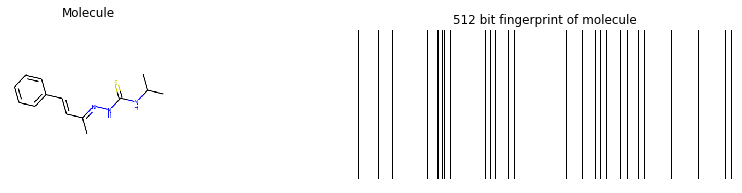

In [16]:
from rdkit.Chem import rdMolDescriptors, Draw

sampled_smiles = df['smiles'].sample().item()
mol = Chem.MolFromSmiles(sampled_smiles)
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2,nBits=512)

print(f'Mol:\t{sampled_smiles}')
print(type(fp))
print(f'Number of bits: {(len(fp))}')
print(f'Bits on: {len(fp.GetOnBits())}')


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (15,3))

ax1.imshow(Draw.MolToImage(mol))
ax1.axis('off')
ax1.set_title('Molecule')

fp_array = np.array([not fp.GetBit(i) for i in range(fp.GetNumBits())]).astype(int).reshape(1,-1)
plt.set_cmap('gray')
ax2.imshow(fp_array, aspect = 200)
ax2.axis('off')
ax2.set_title('512 bit fingerprint of molecule')
plt.show()

In [17]:
bit_info = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bit_info)
on_bits = list(fp.GetOnBits())
for i in on_bits[0:4]:
    print(f'Bit: {i} \t Info: {bit_info[i]}')

Bit: 1 	 Info: ((1, 0),)
Bit: 31 	 Info: ((10, 1),)
Bit: 97 	 Info: ((5, 0),)
Bit: 110 	 Info: ((5, 1),)


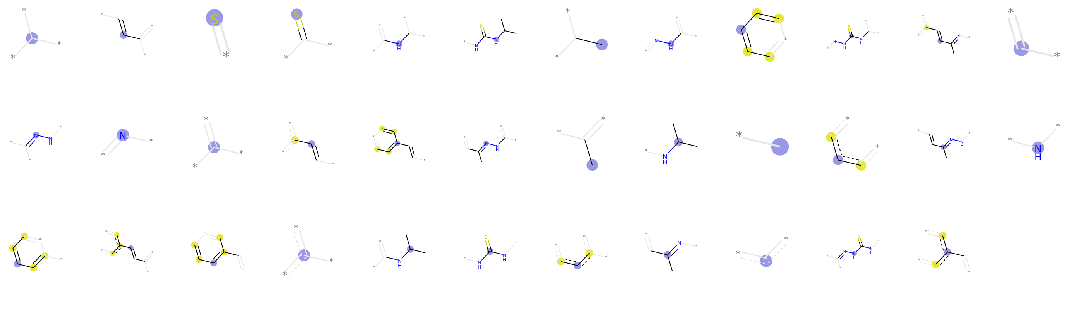

In [20]:
fig, axes = plt.subplots(3,12, figsize=(15,5))
for bit,ax in zip(on_bits, axes.flatten()):
    ax.imshow(Draw.DrawMorganBit(mol, bit,bit_info),
             interpolation='none')
    ax.axis('off')

plt.tight_layout()
plt.axis('off')
plt.show()